<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/PINNS%E8%87%AA%E5%88%86%E3%81%A7%E4%BD%9C%E3%82%8B%EF%BC%81Helmholt%E6%96%B9%E7%A8%8B%E5%BC%8F_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [75]:
print(device)

cuda


# Helmholt方程式
### 厳密解
$(4π)^2sin(4πx)sin(4πy)$

In [76]:
import numpy as np

# x, y の範囲と刻み幅の設定
x_range = np.arange(0, 1.001, 0.001)
y_range = np.arange(0, 1.001, 0.001)

# exact_dataを格納する辞書の初期化
exact_data = {'x': [], 'y': [], 'z': []}

# x, y のループを回して exact を計算し exact_data に格納
for x in x_range:
    for y in y_range:
        exact = (4*np.pi)*(4*np.pi)*np.sin(4*np.pi*x)*np.sin(4*np.pi*y)
        exact_data['x'].append(x)
        exact_data['y'].append(y)
        exact_data['z'].append(exact)

# exact_dataをnumpy配列に変換
exact_data['x'] = np.array(exact_data['x'])
exact_data['y'] = np.array(exact_data['y'])
exact_data['z'] = np.array(exact_data['z'])


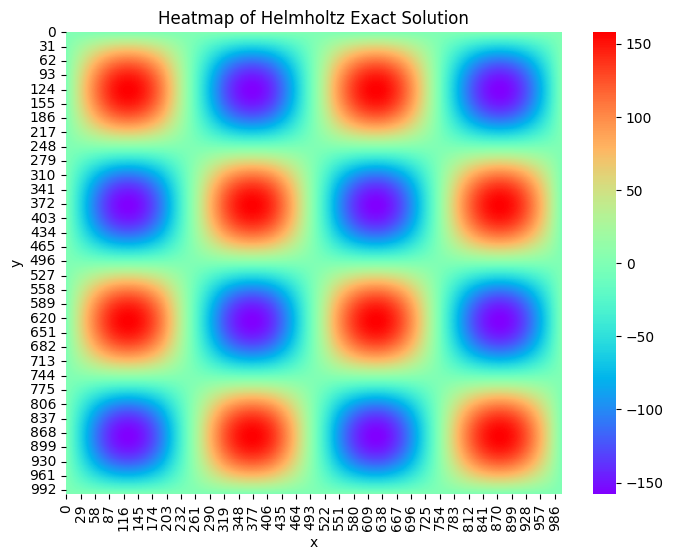

In [77]:
import seaborn as sns

# exact_dataからzを取得
z = exact_data['z']

# 2次元ヒートマップの作成
plt.figure(figsize=(8, 6))
sns.heatmap(z.reshape(1001, 1001), cmap='rainbow')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of Helmholtz Exact Solution')
plt.show()


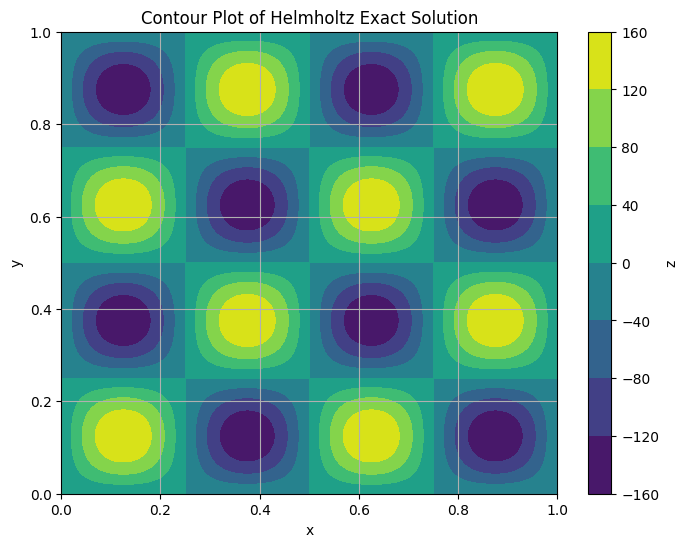

In [78]:
import matplotlib.pyplot as plt

# exact_dataからx, y, zを取得
x = exact_data['x']
y = exact_data['y']
z = exact_data['z']

# 2次元プロットの作成
plt.figure(figsize=(8, 6))
plt.contourf(x.reshape(1001, 1001), y.reshape(1001, 1001), z.reshape(1001, 1001), cmap='viridis')
plt.colorbar(label='z')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of Helmholtz Exact Solution')
plt.grid(True)
plt.show()


### Loss関数の定義
$ -\frac{\partial^2 u}{\partial x^2} -\frac{\partial^2 u}{\partial y^2} -(4\pi)^2u $

In [79]:
criteria = nn.MSELoss()

In [80]:
def physics_informed_loss(x, y, net):
  u = net(x, y)

  u_x = torch.autograd.grad(
    u, x,
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]
  u_xx = torch.autograd.grad(
    u_x, x,
    grad_outputs=torch.ones_like(u_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]

  u_y = torch.autograd.grad(
    u, y,
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]

  u_yy = torch.autograd.grad(
    u_y, y,
    grad_outputs=torch.ones_like(u_y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
  )[0]

  pinn_loss = (-1 * u_xx)+( -1*u_yy )+( -1* (4*np.pi)*(4*np.pi)*u ) # 損失
  zeros_t = torch.zeros(pinn_loss.size()).to(device) # クライテリア側もゼロで規定
  pinn_loss_ = criteria(pinn_loss, zeros_t)
  return pinn_loss_

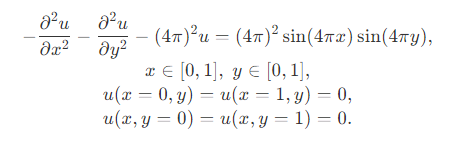

### 境界条件に関する定義

In [81]:
#====================================================
x_bc = np.array([0.0, 1.0])
y_bc = np.array([0.0, 1.0])
bc_sample_size = 500
t_bc = np.linspace(0, 1.0, bc_sample_size)

# x = 0.0
X_bc1 = np.zeros([bc_sample_size, 3])
X_bc1[:,0] = 0.0
X_bc1[:,1] = t_bc
X_bc1[:,2] = y_bc[0]

# x = 1.0
X_bc2 = np.zeros([bc_sample_size, 3])
X_bc2[:,0] = 1.0
X_bc2[:,1] = t_bc
X_bc2[:,2] = y_bc[1]

# y = 0.0
Y_bc1 = np.zeros([bc_sample_size, 3])
Y_bc1[:,0] = t_bc
Y_bc1[:,1] = 0.0
Y_bc1[:,2] = x_bc[0]

# y = 1.0
Y_bc2 = np.zeros([bc_sample_size, 3])
Y_bc2[:,0] = t_bc
Y_bc2[:,1] = 1.0
Y_bc2[:,2] = x_bc[1]

# stack
X_bc_stack = np.vstack([X_bc1, X_bc2, Y_bc1, Y_bc2])
u_bc_stack = np.zeros(X_bc_stack.shape[0])

X_bc_t = torch.tensor(X_bc_stack, requires_grad=True).float().to(device)
u_bc_t = torch.tensor(u_bc_stack, requires_grad=True).float().to(device).unsqueeze(dim=1)


In [82]:

def boundary_condition_loss(x, y, net, u_bc):
  u = net(x, y)
  bc_condition_loss = criteria(u, u_bc)
  return bc_condition_loss


# 空間のサンプリング

In [83]:
# sampling point
x_ = np.linspace(0,1,100)
y_ = np.linspace(0,1,100)
X, Y = np.meshgrid(x_, y_, indexing='ij')
x_flat = X.flatten()
y_flat = Y.flatten()

# sampling size
sampling_size = 5000
random_idx = np.random.choice(np.arange(x_flat.shape[0]),size=sampling_size,replace=False)

#
# sampling
#
x_sampled = x_flat[random_idx]
y_sampled = y_flat[random_idx]
X_sampled = np.zeros([sampling_size,2])
X_sampled[:,0] = x_sampled
X_sampled[:,1] = y_sampled
X_sample_t = torch.tensor(X_sampled,requires_grad=True).float().to(device)

# MLP定義

In [84]:
class PINN(torch.nn.Module):
  def __init__(self,activation='relu'):
    super().__init__()
    self.regressor = nn.Linear(5, 1)
    self.activation = activation
    self.linear1 = self.linear(2,5,activation = self.activation)
    self.linear2 = self.linear(5,20,activation = self.activation)
    self.linear3 = self.linear(20,40,activation = self.activation)
    self.linear4 = self.linear(40,40,activation = self.activation)
    self.linear5 = self.linear(40,40,activation = self.activation)
    self.linear6 = self.linear(40,20,activation = self.activation)
    self.linear7 = self.linear(20,10,activation = self.activation)
    self.linear8 = self.linear(10,5,activation = self.activation)

  def linear(self, in_features, out_features, activation='relu'):
    layers = [nn.Linear(in_features, out_features)]
    if activation == 'relu':
      layers.append(nn.ReLU(inplace=True))
    elif activation == 'tanh':
      layers.append(nn.Tanh())
    else:
      layers.append(nn.Sigmoid())
    net = nn.Sequential(*layers)
    return net
  def forward(self,x,t):
    inputs = torch.cat([x,t],axis=1)
    out = self.linear1(inputs)
    out = self.linear2(out)
    out = self.linear3(out)
    out = self.linear4(out)
    out = self.linear5(out)
    out = self.linear6(out)
    out = self.linear7(out)
    out = self.linear8(out)
    out = self.regressor(out)
    return out

# Opti設定

In [85]:
net = PINN(activation='tanh').to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
num_epoch = 10000

In [86]:
losses=[]
pinn_losses=[]
bnd_losses=[]

for epoch in range(num_epoch):
  optimizer.zero_grad()
  #
  # PINN loss
  #
  x_sampled = X_sample_t[:,0].unsqueeze(dim=-1).to(device)
  y_sampled = X_sample_t[:,1].unsqueeze(dim=-1).to(device)
  pinn_loss = physics_informed_loss(x_sampled, y_sampled, net)
  #
  # Initial loss
  #
 # x_ini = X_ini_t[:,0].unsqueeze(dim=-1).to(device)
 # t_ini = X_ini_t[:,1].unsqueeze(dim=-1).to(device)
 # ini_loss = initial_condition_loss(x_ini, t_ini, net, u_ini_t)
  #
  # bc loss
  #
  x_bnd = X_bc_t[:,0].unsqueeze(dim=-1).to(device)
  y_bnd = X_bc_t[:,1].unsqueeze(dim=-1).to(device)
  bnd_loss = boundary_condition_loss(x_bnd,y_bnd,net,u_bc_t)

  loss = pinn_loss  + bnd_loss
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  pinn_losses.append(pinn_loss.item())
  bnd_losses.append(bnd_loss.item())

  if epoch % 500 == 0:
    loss_ = loss.item()
    pinn_loss_ = pinn_loss.item()
    #ini_loss_ = ini_loss.item()
    bnd_loss_ = bnd_loss.item()
    print(f'epoch:{epoch:.3e},loss:{loss_:.3e},pinn:{pinn_loss_:.3e},bnd:{bnd_loss:.3e}')

epoch:0.000e+00,loss:7.515e+02,pinn:7.515e+02,bnd:3.013e-02
epoch:5.000e+02,loss:2.843e-05,pinn:2.843e-05,bnd:2.512e-09
epoch:1.000e+03,loss:2.730e-05,pinn:2.730e-05,bnd:2.408e-09
epoch:1.500e+03,loss:2.667e-05,pinn:2.666e-05,bnd:2.348e-09
epoch:2.000e+03,loss:2.583e-05,pinn:2.583e-05,bnd:2.273e-09
epoch:2.500e+03,loss:2.479e-05,pinn:2.479e-05,bnd:2.180e-09
epoch:3.000e+03,loss:2.352e-05,pinn:2.352e-05,bnd:2.067e-09
epoch:3.500e+03,loss:2.203e-05,pinn:2.203e-05,bnd:1.934e-09
epoch:4.000e+03,loss:2.032e-05,pinn:2.031e-05,bnd:1.782e-09
epoch:4.500e+03,loss:1.674e-05,pinn:1.674e-05,bnd:1.486e-09
epoch:5.000e+03,loss:1.037e-05,pinn:1.037e-05,bnd:8.551e-10
epoch:5.500e+03,loss:1.442e-04,pinn:1.442e-04,bnd:9.005e-09
epoch:6.000e+03,loss:1.987e-05,pinn:1.987e-05,bnd:1.967e-09
epoch:6.500e+03,loss:3.089e-06,pinn:3.089e-06,bnd:2.715e-10
epoch:7.000e+03,loss:1.527e-06,pinn:1.527e-06,bnd:1.343e-10
epoch:7.500e+03,loss:6.958e-07,pinn:6.958e-07,bnd:6.114e-11
epoch:8.000e+03,loss:3.312e-07,pinn:3.31

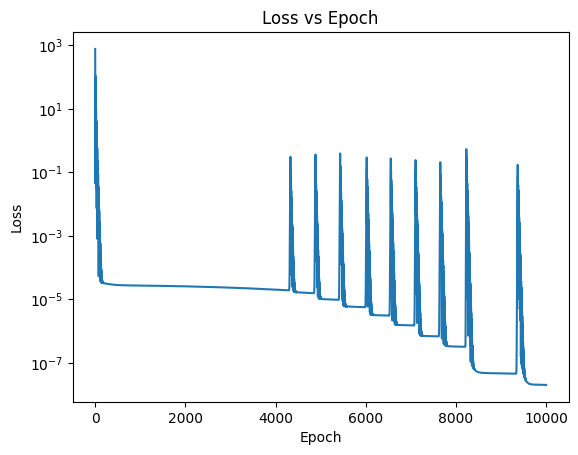

In [87]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.yscale('log')
plt.show()

# 推論してみる

In [88]:
X_test = np.zeros([x_flat.shape[0],2])
X_test[:,0] = x_flat
X_test[:,1] = y_flat

X_test_t = torch.tensor(X_test).float().to(device)
x_test = X_test_t[:,0].unsqueeze(dim=-1)
y_test = X_test_t[:,1].unsqueeze(dim=-1)
u_pred = net(x_test , y_test)

xtest=x_test.cpu().numpy()
ytest=y_test.cpu().numpy()
upred=u_pred.cpu().detach().numpy()


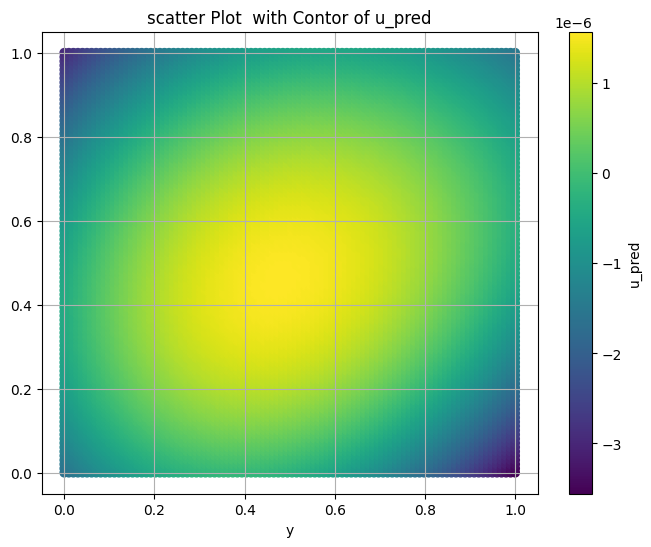

In [89]:
plt.figure(figsize=(8,6))
plt.scatter(xtest, ytest, c=upred, cmap='viridis')
plt.colorbar(label='u_pred')
plt.xlabel('x')
plt.xlabel('y')
plt.title('scatter Plot  with Contor of u_pred')
plt.grid(True)
plt.show()

NameError: name 'u_pred_arr' is not defined

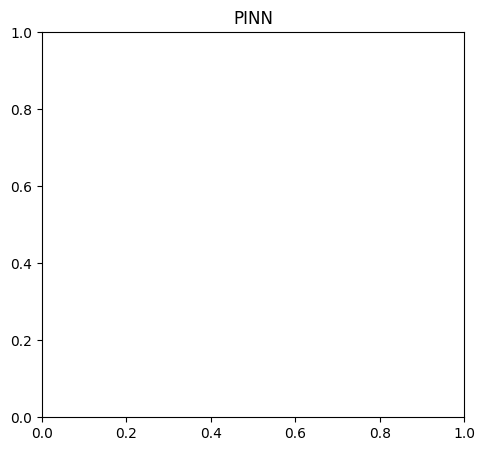

In [90]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('PINN')
sns.heatmap(u_pred_arr,cmap='rainbow',vmin=-1,vmax=1)
plt.subplot(1,2,2)
plt.title('Exact')
sns.heatmap(u_exact,cmap='rainbow',vmin=-1,vmax=1)